# Outline
* Load in data
* load in libraries
* choose features for modeling
* encode/dummify categorical features IF NEEDED
* build a model that meets the assumptions of an OLS
* cross validate the model with sklearn
* interpret the model 


# Modeling Flow for OLS
* build models in statsmodels until it meets all assumptions
    * build models on all the data 
* build the validated model in sklearn and cross validation test 
* final model 
    * or iterate on it to make it better
    

# Methodology
Step 1: Develop Functions that will allow you to experiment with ease

    Create a function that builds a model given a target and features
    Create a function that will test Multicollinearity of features in a feature space
    Create a function that will validate the assumptions of OLS

Step 2: Begin EDA and Feature Selection/Engineering/Transforming

Step 3: Experiment with various feature spaces

Step 4: Land on a good model and cross-validate

Step 5: Interpret your final model

    What does it mean in regards to business?
    What does it mean in regards to the math/statistics of the data?
    Is the model good? Does it make sense? Why or why not?
    What data would you like in the future?


In [19]:
# Load in libraries
import warnings
from importlib import reload

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms

from statsFunctions import check_model

from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns


In [20]:
# load in data
df = pd.read_csv('../data/proc_kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view_rank,...,long,sqft_living15,sqft_lot15,date_month,date_day,date_year,renovated_status,sqft_living15_diff,sqft_lot15_diff,scenic_status
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,-122.257,1340,5650,10,13,2014,UNK,-160,0,N
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,-122.319,1690,7639,12,9,2014,Y,880,-397,N
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,-122.233,2720,8062,2,25,2015,UNK,-1950,1938,N
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,-122.393,1360,5000,12,9,2014,UNK,600,0,N
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,-122.045,1800,7503,2,18,2015,UNK,-120,577,N


In [21]:
print(df.shape)

(21420, 28)


# Build a model
Get things rolling by creating a model. Doesn't have to be stellar but is your entry point to creating something that's not garbage.

In [22]:
target = 'price'
features_to_use = ['sqft_living', 'view_rank']

In [23]:
ols = check_model(df, features_to_use=features_to_use, target_col=target, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.853
Model:                            OLS   Adj. R-squared (uncentered):              0.853
Method:                 Least Squares   F-statistic:                          6.208e+04
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:18:06   Log-Likelihood:                     -2.9672e+05
No. Observations:               21420   AIC:                                  5.935e+05
Df Residuals:                   21418   BIC:                                  5.935e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

# Explore the feature space

In [24]:
# let's find some features based on their correlation scores

def get_columns_correlations(df, target):
    columns_correlations = []
    columns_non_numeric = []
    
    for column in df.drop(columns=[target]).columns:
        try:
            # using .corr on each column to the target
            corr = np.abs(df[column].corr(df[target]))
            t = (column, corr)
            columns_correlations.append(t)
        except:
            columns_non_numeric.append(column)
    return columns_correlations


def get_columns_correlations_above_threshold(all_col_corrs):
    correlated_features_above_2 = [t[0] for t in all_col_corrs if t[1] >= 0.20]
    return correlated_features_above_2

In [25]:
all_columns_correlations = get_columns_correlations(df, target)
all_columns_correlations

[('id', 0.018449520780333174),
 ('bedrooms', 0.3096400152273569),
 ('bathrooms', 0.5252152971165561),
 ('sqft_living', 0.7012948591175873),
 ('sqft_lot', 0.08878895326280657),
 ('floors', 0.254971632871279),
 ('waterfront', 0.26491453896199607),
 ('view_rank', 0.39278723176279356),
 ('condition', 0.03421927419820454),
 ('grade', 0.666834956438976),
 ('sqft_above', 0.6044238993986455),
 ('sqft_basement', 0.3212640164141516),
 ('yr_built', 0.051011811800142234),
 ('yr_renovated', 0.11827845194955379),
 ('zipcode', 0.0511690561394496),
 ('lat', 0.30643893771248304),
 ('long', 0.01982564494658666),
 ('sqft_living15', 0.5837916994556079),
 ('sqft_lot15', 0.08204522248404936),
 ('date_month', 0.007920043895258681),
 ('date_day', 0.014085460291666968),
 ('date_year', 0.0013854043606439264),
 ('sqft_living15_diff', 0.40602839520777456),
 ('sqft_lot15_diff', 0.04975026762471563)]

In [26]:
# let's get all columns with correlation above a threshold of 0.20
correlated_features_above_2 = [t[0] for t in all_columns_correlations if t[1] >= 0.20]
correlated_features_above_2

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view_rank',
 'grade',
 'sqft_above',
 'sqft_basement',
 'lat',
 'sqft_living15',
 'sqft_living15_diff']

In [27]:
whole_feature_space = correlated_features_above_2
whole_feature_space.append(target)

In [28]:
# Let's hone in on these promising features
correlated_df = df[whole_feature_space]
correlated_df.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view_rank,grade,sqft_above,sqft_basement,lat,sqft_living15,sqft_living15_diff,price
0,3,1.00,1180,1.0,0,0,7,1180,0,47.5112,1340,-160,221900.0
1,3,2.25,2570,2.0,0,0,7,2170,400,47.7210,1690,880,538000.0
2,2,1.00,770,1.0,0,0,6,770,0,47.7379,2720,-1950,180000.0
3,4,3.00,1960,1.0,0,0,7,1050,910,47.5208,1360,600,604000.0
4,3,2.00,1680,1.0,0,0,8,1680,0,47.6168,1800,-120,510000.0


### Plot a scatter matrix

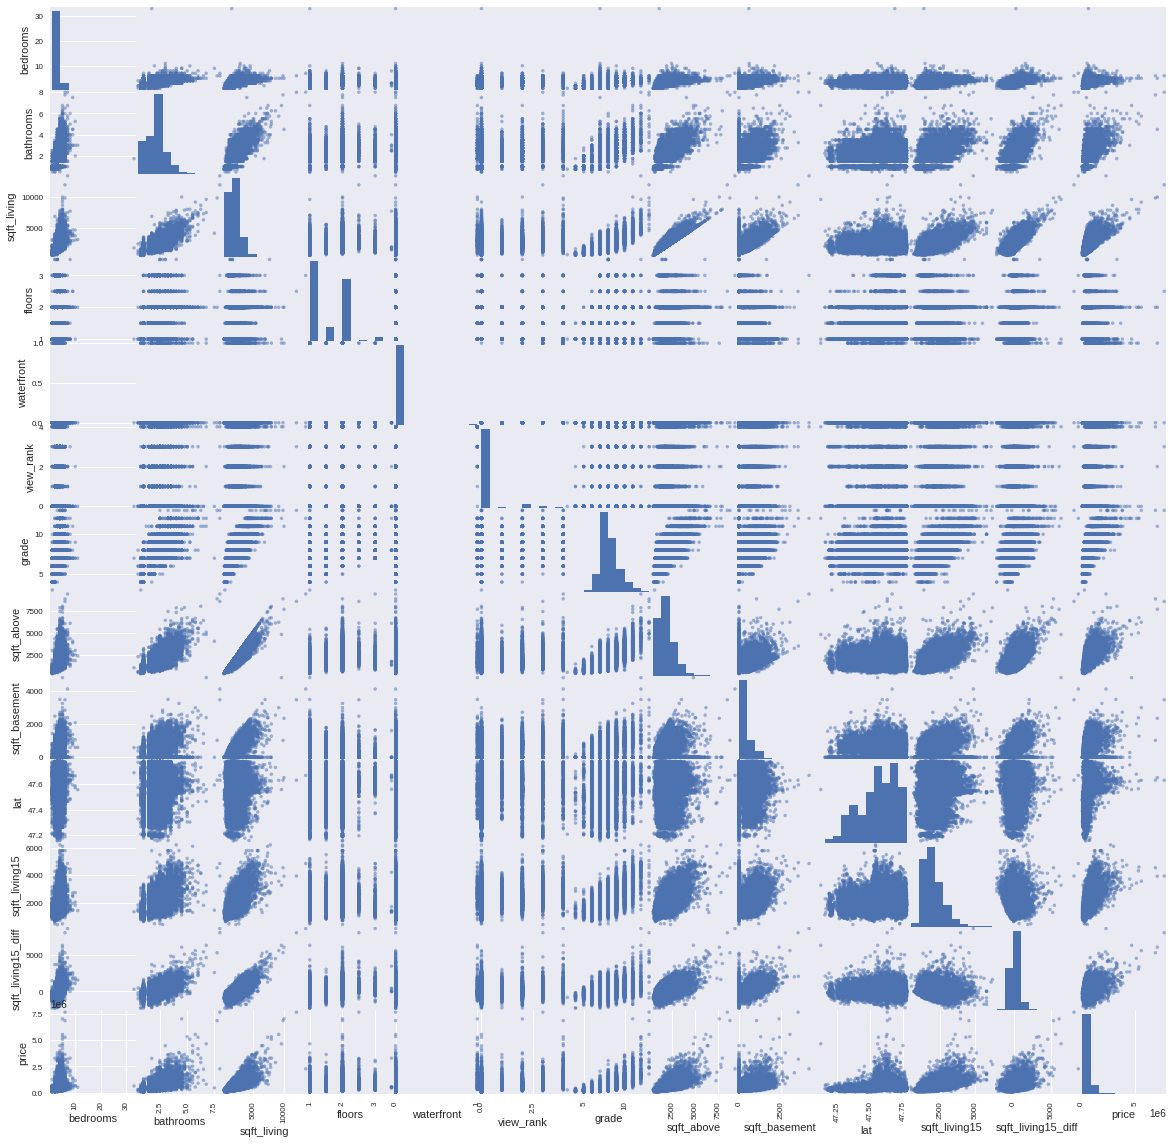

In [29]:
pd.plotting.scatter_matrix(correlated_df, figsize=(20,20))
plt.show()

### BLEH!    Do some log transforms on our skewed continuous variables.
* price, our target, is super skewed
* sqft_living15
* lat
* sqft_basement
* sqft_above
* sqft_living

__NOTE__ Distribution for __sqft_living15_diff__ is skewed but it has negative values so we can't try to use log transform to address skew. __OMIT__ from list of continous variables moving forward.


### Categorical variables are:
* bedrooms
* bathrooms
* floors
* view_rank
* waterfront
* grade
* condition

<function matplotlib.pyplot.show(close=None, block=None)>

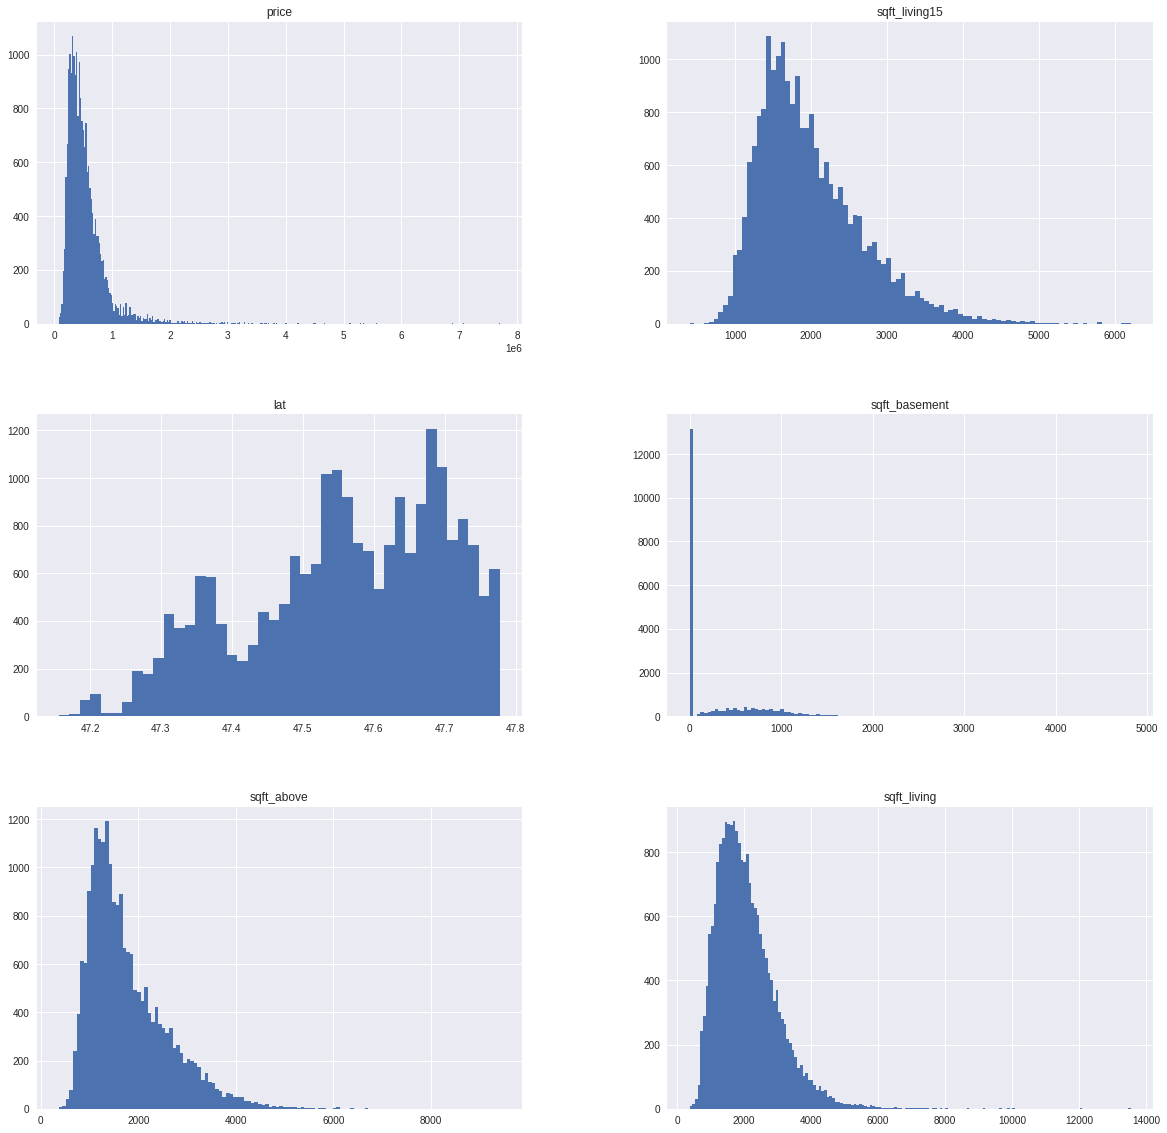

In [57]:
continuous_col_names = ['price','sqft_living15', 'lat', 'sqft_basement', 'sqft_above', 'sqft_living']
continuous_df = correlated_df[continuous_col_names]
continuous_df.hist(figsize=[20, 20], bins='auto')
plt.show

In [58]:
# Note that sqft_basement has a huge number of zeros. 
# Drop this zero-inflated variable for now and just use the features which don't have this characteristic. 
continuous_df.drop(['sqft_basement'], axis=1, inplace=True)
continuous_df.head()

,price,sqft_living15,lat,sqft_above,sqft_living
0,221900.0,1340,47.5112,1180,1180
1,538000.0,1690,47.7210,2170,2570
2,180000.0,2720,47.7379,770,770
3,604000.0,1360,47.5208,1050,1960
4,510000.0,1800,47.6168,1680,1680



### Perform log transformations for those variables that need skew correction
Recall that a common option for transforming non-normal variable distributions is to try applying a logarithmic function and observe its impact of the distribution. Give it a go!

* price
* sqft_living15
* lat
* sqft_above
* sqft_living

In [59]:
# Now select those variables that need skew correction
non_norm_col_names = ['price','sqft_living15', 'lat', 'sqft_above', 'sqft_living']
non_norm_df = continuous_df[non_norm_col_names]

In [60]:
log_names = [f'{column}_log' for column in non_norm_df.columns]
cont_log_transformed_df = np.log(non_norm_df)
cont_log_transformed_df.columns = log_names
cont_log_transformed_df.head()

,price_log,sqft_living15_log,lat_log,sqft_above_log,sqft_living_log
0,12.309982,7.200425,3.860965,7.073270,7.073270
1,13.195614,7.432484,3.865372,7.682482,7.851661
2,12.100712,7.908387,3.865726,6.646391,6.646391
3,13.311329,7.215240,3.861168,6.956545,7.580700
4,13.142166,7.495542,3.863186,7.426549,7.426549


<function matplotlib.pyplot.show(close=None, block=None)>

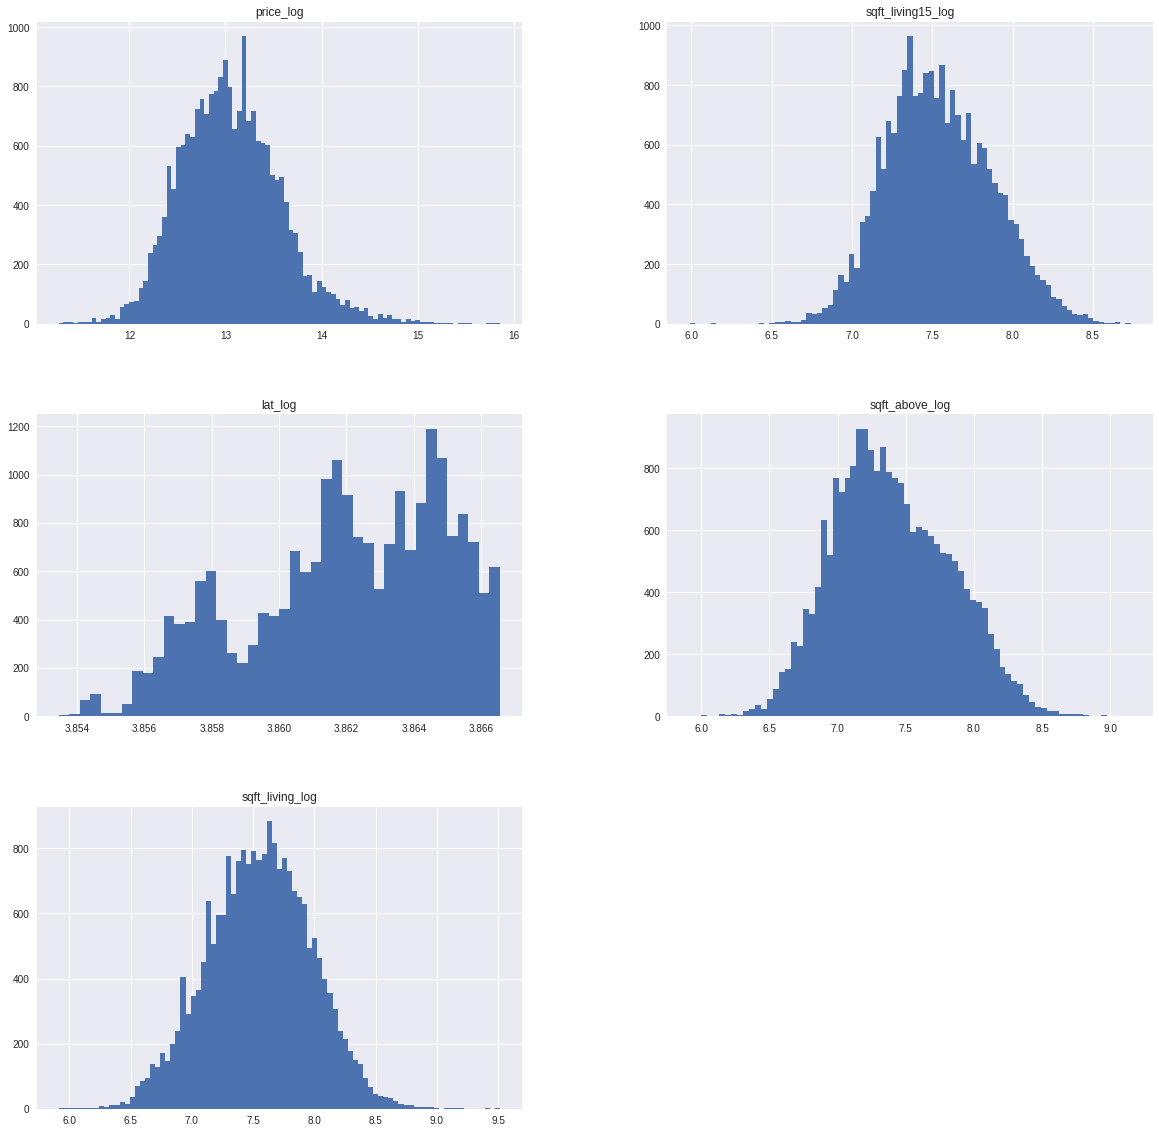

In [61]:
cont_log_transformed_df.hist(figsize=(20, 20), bins='auto')
plt.show

### Inspect the log transformed continuous variable distributions.  If the skew was improved, that variable will be standardized and  included in the final feature space/set.
* price_log - our target so of course it will be included - IMPROVED 
* sqft_living_log15 - IMPROVED
* lat_log - no improvement - drop it
* sqft_above_log - IMPROVED
* sqft_living_log - IMPROVE

In [62]:
# normalize function for features that were log transformed
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# drop features that didn't see skew improvement
cont_log_transformed_df.drop(['lat_log'], axis=1, inplace=True)
cont_log_transformed_df = cont_log_transformed_df.apply(normalize)

<function matplotlib.pyplot.show(close=None, block=None)>

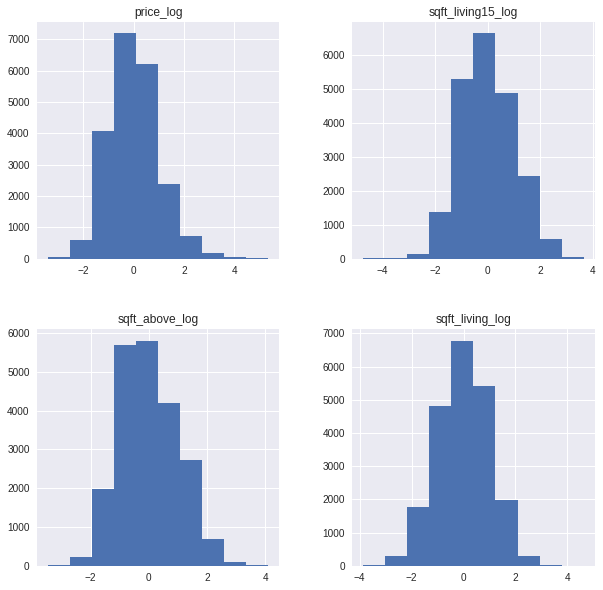

In [63]:
cont_log_transformed_df.hist(figsize=(10, 10))
plt.show


### My previous (poor) model didn't include Categorical variables. One-hot-encode these and use them for modeling to see I get a better model.


### > 0.20 Correlation threshold Categorical variables are:
* bedrooms  ('bedrooms', 0.3096400152273569),
* bathrooms   ('bathrooms', 0.5252152971165561),
* floors   ('floors', 0.254971632871279),
* view_rank  ('view_rank', 0.39278723176279356),
* waterfront  ('waterfront', 0.26491453896199607),
* grade ('grade', 0.666834956438976)


In [37]:
correlated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedrooms            21420 non-null  int64  
 1   bathrooms           21420 non-null  float64
 2   sqft_living         21420 non-null  int64  
 3   floors              21420 non-null  float64
 4   waterfront          21420 non-null  int64  
 5   view_rank           21420 non-null  int64  
 6   grade               21420 non-null  int64  
 7   sqft_above          21420 non-null  int64  
 8   sqft_basement       21420 non-null  int64  
 9   lat                 21420 non-null  float64
 10  sqft_living15       21420 non-null  int64  
 11  sqft_living15_diff  21420 non-null  int64  
 12  price               21420 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 2.1 MB


In [38]:
# one-hot encode the categorical variables
categorical_col_names = ['bedrooms', 'bathrooms', 'floors', 'view_rank', 'waterfront', 'grade', 'condition']
corr_cat_df = correlated_df[categorical_col_names]
corr_cat_df.head()

,bedrooms,bathrooms,floors,view_rank,waterfront,grade
0,3,1.00,1.0,0,0,7
1,3,2.25,2.0,0,0,7
2,2,1.00,1.0,0,0,6
3,4,3.00,1.0,0,0,7
4,3,2.00,1.0,0,0,8


In [39]:
# DON'T FALL INTO THE DUMMY TRAP!  drop_first=True :)
corr_ohe_df = pd.get_dummies(corr_cat_df, columns=categorical_col_names, prefix=categorical_col_names, drop_first=True)


In [40]:
corr_ohe_df.head()

,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bedrooms_10,bedrooms_11,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [41]:
### concat the continous and categorical likely features into a single datafame for model creation
likely_features_df = pd.concat([cont_log_transformed_df, corr_ohe_df], axis = 1)

In [42]:
likely_features_df.head()

,price_log,sqft_living15_log,sqft_above_log,sqft_living_log,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,-1.417103,-1.038290,-0.756736,-1.129304,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.273605,-0.329584,0.669188,0.706321,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-1.816608,1.123821,-1.755890,-2.135982,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.494510,-0.993045,-1.029941,0.067332,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.171570,-0.137005,0.070150,-0.296190,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [28]:
#likely_features_df.info()

In [44]:
likely_feature_names = list(likely_features_df.columns)
likely_feature_names

['price_log',
 'sqft_living15_log',
 'sqft_above_log',
 'sqft_living_log',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bedrooms_6',
 'bedrooms_7',
 'bedrooms_8',
 'bedrooms_9',
 'bedrooms_10',
 'bedrooms_11',
 'bedrooms_33',
 'bathrooms_0.75',
 'bathrooms_1.0',
 'bathrooms_1.25',
 'bathrooms_1.5',
 'bathrooms_1.75',
 'bathrooms_2.0',
 'bathrooms_2.25',
 'bathrooms_2.5',
 'bathrooms_2.75',
 'bathrooms_3.0',
 'bathrooms_3.25',
 'bathrooms_3.5',
 'bathrooms_3.75',
 'bathrooms_4.0',
 'bathrooms_4.25',
 'bathrooms_4.5',
 'bathrooms_4.75',
 'bathrooms_5.0',
 'bathrooms_5.25',
 'bathrooms_5.5',
 'bathrooms_5.75',
 'bathrooms_6.0',
 'bathrooms_6.25',
 'bathrooms_6.5',
 'bathrooms_6.75',
 'bathrooms_7.5',
 'bathrooms_7.75',
 'bathrooms_8.0',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'view_rank_1',
 'view_rank_2',
 'view_rank_3',
 'view_rank_4',
 'waterfront_1',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10'

### Now that we've got some likely features (continous variables  that have been transformed and normalized and categorical variables that have been one-hot-encoded), create another model

In [45]:
likely_feature_names.remove('price_log')

In [46]:
ols_round_two = check_model(likely_features_df, features_to_use=likely_feature_names, target_col='price_log', show_summary=True)

sqft_above_log surpassed threshold with vif=6.449326894142982
sqft_living_log surpassed threshold with vif=7.98590255249449
bathrooms_0.75 surpassed threshold with vif=14.72601047896704
bathrooms_1.0 surpassed threshold with vif=42.32411955431855
bathrooms_1.5 surpassed threshold with vif=30.121036348523727
bathrooms_1.75 surpassed threshold with vif=41.168865843664264
bathrooms_2.0 surpassed threshold with vif=24.43955555763138
bathrooms_2.25 surpassed threshold with vif=48.295765646586126
bathrooms_2.5 surpassed threshold with vif=46.83910774866814
bathrooms_2.75 surpassed threshold with vif=32.000130231863864
bathrooms_3.0 surpassed threshold with vif=47.72515621955527
bathrooms_3.25 surpassed threshold with vif=15.071967014873795
bathrooms_3.5 surpassed threshold with vif=44.14358993115183
bathrooms_3.75 surpassed threshold with vif=32.350680084570776
bathrooms_4.0 surpassed threshold with vif=28.138620783326125
bathrooms_4.25 surpassed threshold with vif=17.022240910082335
bathroo

Residuals failed test/tests


### This new model has multicollinearity. Iterate by removing features.

In [47]:
likely_feature_names2 = likely_feature_names

In [48]:
# remove all bathroom cols
likely_feature_names2.remove('bathrooms_0.75')
likely_feature_names2.remove('bathrooms_1.0')
likely_feature_names2.remove('bathrooms_1.25')
likely_feature_names2.remove('bathrooms_1.5')
likely_feature_names2.remove('bathrooms_1.75')
likely_feature_names2.remove('bathrooms_2.0')
likely_feature_names2.remove('bathrooms_2.25')
likely_feature_names2.remove('bathrooms_2.5')
likely_feature_names2.remove('bathrooms_2.75')
likely_feature_names2.remove('bathrooms_3.0')
likely_feature_names2.remove('bathrooms_3.25')
likely_feature_names2.remove('bathrooms_3.5')
likely_feature_names2.remove('bathrooms_3.75')
likely_feature_names2.remove('bathrooms_4.0')
likely_feature_names2.remove('bathrooms_4.25')
likely_feature_names2.remove('bathrooms_4.5')
likely_feature_names2.remove('bathrooms_4.75')
likely_feature_names2.remove('bathrooms_5.0')
likely_feature_names2.remove('bathrooms_5.25')
likely_feature_names2.remove('bathrooms_5.75')
likely_feature_names2.remove('bathrooms_6.0')
likely_feature_names2.remove('bathrooms_6.25')
likely_feature_names2.remove('bathrooms_6.5')
likely_feature_names2.remove('bathrooms_6.75')
likely_feature_names2.remove('bathrooms_7.5')
likely_feature_names2.remove('bathrooms_7.75')
likely_feature_names2.remove('bathrooms_8.0')

In [49]:
likely_feature_names2
likely_feature_names2.remove('bathrooms_5.5')

In [50]:
likely_feature_names2

['sqft_living15_log',
 'sqft_above_log',
 'sqft_living_log',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bedrooms_6',
 'bedrooms_7',
 'bedrooms_8',
 'bedrooms_9',
 'bedrooms_10',
 'bedrooms_11',
 'bedrooms_33',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'view_rank_1',
 'view_rank_2',
 'view_rank_3',
 'view_rank_4',
 'waterfront_1',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13']

In [51]:
ols_round_3 = check_model(likely_features_df, features_to_use=likely_feature_names2, target_col='price_log', show_summary=True)

sqft_above_log surpassed threshold with vif=6.23064619116281
sqft_living_log surpassed threshold with vif=6.577510118276761
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.609
Model:                            OLS   Adj. R-squared (uncentered):              0.609
Method:                 Least Squares   F-statistic:                              980.6
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:19:51   Log-Likelihood:                         -20330.
No. Observations:               21420   AIC:                                  4.073e+04
Df Residuals:                   21386   BIC:                                  4.100e+04
Df Model:                          34                                                  
Covariance Type:            nonrobust        

#### Now down to just 2 problematic (multicollinear) variables. They make sense too: sqft_living_log  and sqft_above_log

Drop one and do another model iteration

In [52]:
likely_feature_names3 = likely_feature_names2
likely_feature_names3.remove('sqft_above_log')
likely_feature_names3

['sqft_living15_log',
 'sqft_living_log',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bedrooms_6',
 'bedrooms_7',
 'bedrooms_8',
 'bedrooms_9',
 'bedrooms_10',
 'bedrooms_11',
 'bedrooms_33',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'view_rank_1',
 'view_rank_2',
 'view_rank_3',
 'view_rank_4',
 'waterfront_1',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13']

In [53]:
ols_round_4 = check_model(likely_features_df, features_to_use=likely_feature_names3, target_col='price_log', show_summary=True)

sqft_living_log surpassed threshold with vif=4.38527667041745
Model contains multicollinear features
                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.604
Model:                            OLS   Adj. R-squared (uncentered):              0.603
Method:                 Least Squares   F-statistic:                              986.9
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:20:01   Log-Likelihood:                         -20482.
No. Observations:               21420   AIC:                                  4.103e+04
Df Residuals:                   21387   BIC:                                  4.129e+04
Df Model:                          33                                                  
Covariance Type:            nonrobust                                                  
                   

### One more time..with feeling!

In [54]:
likely_feature_names4 = likely_feature_names3
likely_feature_names4.remove('sqft_living_log')
likely_feature_names4

['sqft_living15_log',
 'bedrooms_2',
 'bedrooms_3',
 'bedrooms_4',
 'bedrooms_5',
 'bedrooms_6',
 'bedrooms_7',
 'bedrooms_8',
 'bedrooms_9',
 'bedrooms_10',
 'bedrooms_11',
 'bedrooms_33',
 'floors_1.5',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'floors_3.5',
 'view_rank_1',
 'view_rank_2',
 'view_rank_3',
 'view_rank_4',
 'waterfront_1',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13']

In [55]:
ols_round_5 = check_model(likely_features_df, features_to_use=likely_feature_names4, target_col='price_log', show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:              price_log   R-squared (uncentered):                   0.579
Model:                            OLS   Adj. R-squared (uncentered):              0.578
Method:                 Least Squares   F-statistic:                              919.2
Date:                Mon, 12 Oct 2020   Prob (F-statistic):                        0.00
Time:                        19:20:10   Log-Likelihood:                         -21128.
No. Observations:               21420   AIC:                                  4.232e+04
Df Residuals:                   21388   BIC:                                  4.257e+04
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Welp, this is still not great but I've learned how to go through the process of feature engineering, model building, and model evaluation. :)

* R squared is 0.579
* The Condition Number is too big - we hope to see something below 30.
* Durbin-Watson test for homoscedasticity - we hope for a vlaue between 1 and 2. This is right against the upper limit.

Big shoutout to Andrea C. for sharing this great resource on understanding the LR results.  https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate 


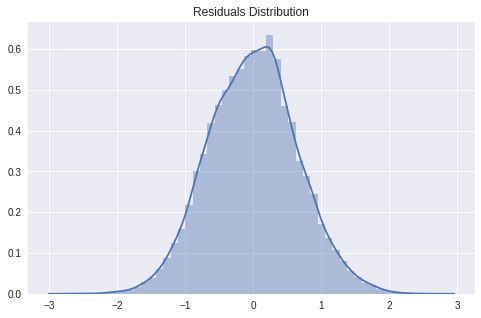

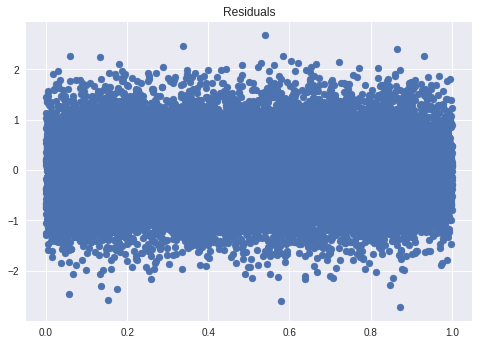

In [56]:
def plot_residuals(ols):
    residuals = ols.resid
    plt.figure(figsize=(8,5))
    plt.title('Residuals Distribution')
    sns.distplot(residuals)
    plt.show()
    plt.figure()
    x_axis = np.linspace(0, 1, len(residuals))
    plt.scatter(x_axis, residuals)
    plt.title('Residuals')
    plt.show()
    
    
plot_residuals(ols_round_5)